In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import f1_score

from model import Autoencoder
from utils import load_graphsage_data
from debug import *

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

### Carregando o dataset

In [2]:
# Import data
dataset_path = '../datasets'
dataset_str = 'pubmed'

num_data, feats, labels, train_ids, val_ids, test_ids = load_graphsage_data(dataset_path, dataset_str)

Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data, now preprocessing..
Data processed


In [3]:
feats.shape, labels.shape, train_ids.shape, val_ids.shape, test_ids.shape

((19717, 500), (19717, 3), (11831,), (3943,), (3943,))

### Hiperparâmetros

In [4]:
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64, 128, 256]

### Treinamento

In [5]:
# Tensorflow implementation

params = list()
best_model = None
min_val_loss = 99999999
n_epochs = 50
best_model_path = 'best_model/pubmed_model'

for lr in learning_rates:
    autoencodertf = Autoencoder(feats.shape[1],
                                hidden_dim=labels.shape[1],
                                learning_rate=lr)
    
    for b_size in batch_sizes:
        print('Learning rate: {}, batch size: {}'.format(lr, b_size))
        train_loss, val_loss, time_per_epoch = autoencodertf.train(feats[train_ids],
                                                                   labels[train_ids],
                                                                   feats[val_ids],
                                                                   labels[val_ids],
                                                                   batch_size=b_size,
                                                                   epochs=n_epochs)
        print('Val loss: {}'.format(val_loss[-1]))
        print('Training time: {} seconds'.format(round(np.sum(time_per_epoch),4)))
        
        # precisão
        preds = autoencodertf.predict(feats[test_ids])
        y_test = np.argmax(labels[test_ids], axis=1)
        y_pred = np.argmax(preds[0], axis=1)
        micro_f1 = f1_score(y_test, y_pred, average='micro')
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        print("macro_f1: {}, micro_f1:{}\n\n".format(macro_f1, micro_f1))
        
        # best model
        if val_loss[-1][0] < min_val_loss:
            min_val_loss = val_loss[-1][0]
            best_model = [lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1]
            autoencodertf.save_model(best_model_path)
        
        params.append([lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1])
        
np.save('results/params', params)
np.save('results/best_params', best_model)

# to load that...
# best_params = np.load('results/best_params.npy', allow_pickle=True)
# lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1 = best_params

Learning rate: 0.01, batch size: 32
Epoch 1 / 50 loss: 9.405606
Epoch 10 / 50 loss: 1.9680955
Epoch 20 / 50 loss: 1.6270456
Epoch 30 / 50 loss: 1.7501824
Epoch 40 / 50 loss: 1.6836352
Epoch 50 / 50 loss: 1.6247962
Val loss: [1.6928716]
Training time: 39.992 seconds
macro_f1: 0.8482399764469433, micro_f1:0.853157494293685


Model saved

Learning rate: 0.01, batch size: 64
Epoch 1 / 50 loss: 39.909435
Epoch 10 / 50 loss: 2.2860947
Epoch 20 / 50 loss: 1.9116464
Epoch 30 / 50 loss: 1.8231435
Epoch 40 / 50 loss: 1.7711976
Epoch 50 / 50 loss: 1.7021848
Val loss: [1.751874]
Training time: 29.5471 seconds
macro_f1: 0.7821849389607447, micro_f1:0.7895003804209992


Learning rate: 0.01, batch size: 128
Epoch 1 / 50 loss: 121.004715
Epoch 10 / 50 loss: 2.4503427
Epoch 20 / 50 loss: 2.0706675
Epoch 30 / 50 loss: 2.030827
Epoch 40 / 50 loss: 1.9461629
Epoch 50 / 50 loss: 1.8242368
Val loss: [1.8549087]
Training time: 24.1822 seconds
macro_f1: 0.6365916673646678, micro_f1:0.6403753487192493


Learni

### Estatisticas do treinamento

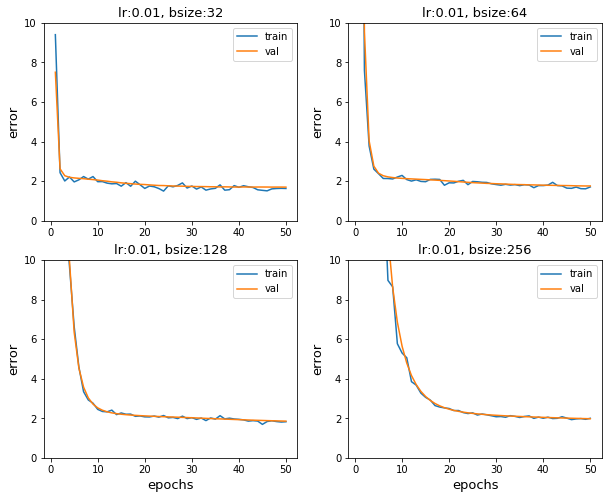

In [6]:
# Convergencia

x = list(range(1,len(train_loss)+1))
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(10,8)
# ax[-1,-1].remove()

idx = 0
for row in range(rows):
    for col in range(cols):
        lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1 = params[idx]
        ax[row][col].set_title('lr:{}, bsize:{}'.format(lr, b_size), fontsize=13)
        if row == 1: ax[row][col].set_xlabel('epochs', fontsize=13)
        ax[row][col].set_ylabel('error', fontsize=13)
        ax[row][col].set_ylim([0,10])
        ax[row][col].plot(x, train_loss, label='train')
        ax[row][col].plot(x, val_loss, label='val')
        ax[row][col].legend()
        idx += 1

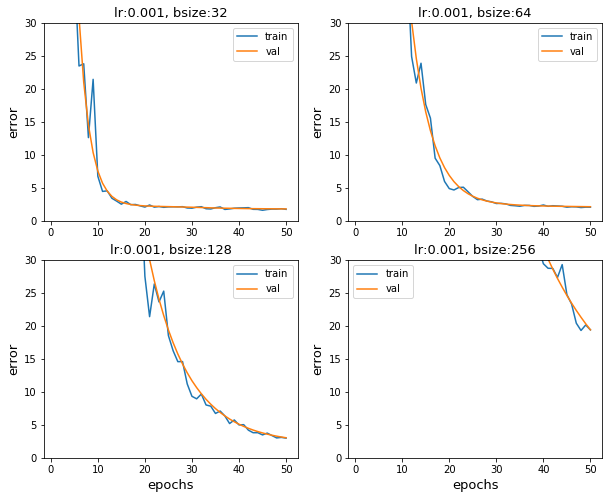

In [7]:
fig, ax = plt.subplots(rows, cols)
fig.set_size_inches(10,8)
# ax[-1,-1].remove()

idx = 4
for row in range(rows):
    for col in range(cols):
        lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1 = params[idx]
        ax[row][col].set_title('lr:{}, bsize:{}'.format(lr, b_size), fontsize=13)
        if row == 1: ax[row][col].set_xlabel('epochs', fontsize=13)
        ax[row][col].set_ylabel('error', fontsize=13)
        ax[row][col].set_ylim([0,30])
        ax[row][col].plot(x, train_loss, label='train')
        ax[row][col].plot(x, val_loss, label='val')
        ax[row][col].legend()
        idx += 1

### Melhor model

In [8]:
lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1 = best_model

print('lr:{}, b_size:{}'.format(lr, b_size))
print('val_loss:', val_loss[-1])
print('average time per epoch: {} seconds'.format(round(np.mean(time_per_epoch),4)))
print("macro_f1: {}, micro_f1:{}".format(macro_f1, micro_f1))

lr:0.01, b_size:32
val_loss: [1.6928716]
average time per epoch: 0.7998 seconds
macro_f1: 0.8482399764469433, micro_f1:0.853157494293685


### Carregando e testando o melhor model

In [9]:
# loading best model
model = Autoencoder(feats.shape[1],
                    hidden_dim=labels.shape[1],
                    learning_rate=lr)

#best_model_path = 'best_model/pubmed_model'
#model.load_model(best_model_path)

train_loss, val_loss, time_per_epoch = model.train(feats[train_ids],
                                                   labels[train_ids],
                                                   feats[val_ids],
                                                   labels[val_ids],
                                                   batch_size=b_size,
                                                   epochs=n_epochs)
print('Val loss: {}'.format(val_loss[-1]))
print('Training time: {} seconds'.format(round(np.sum(time_per_epoch),4)))


# test
preds = model.predict(feats[test_ids])
y_test = np.argmax(labels[test_ids], axis=1)
y_pred = np.argmax(preds[0], axis=1)
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("\nmacro_f1: {}, micro_f1:{}".format(macro_f1, micro_f1))    

Epoch 1 / 50 loss: 9.334122
Epoch 10 / 50 loss: 1.913132
Epoch 20 / 50 loss: 1.5812062
Epoch 30 / 50 loss: 1.7675674
Epoch 40 / 50 loss: 1.7346537
Epoch 50 / 50 loss: 1.6124899
Val loss: [1.6920868]
Training time: 42.6508 seconds

macro_f1: 0.8449447978654714, micro_f1:0.8503677402992645


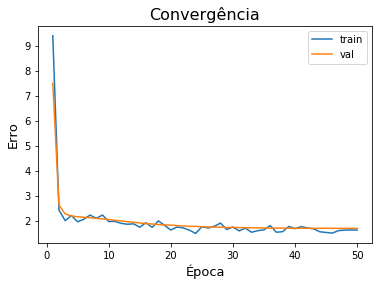

In [10]:
# Convergencia
lr, b_size, train_loss, val_loss, time_per_epoch, micro_f1, macro_f1 = best_model
x = list(range(1,len(train_loss)+1))

fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.set_title('Convergência', fontsize=16)
ax.set_xlabel('Época', fontsize=13)
ax.set_ylabel('Erro', fontsize=13)
ax.plot(x, train_loss, label='train')
ax.plot(x, val_loss, label='val')
ax.legend()
fig.savefig('results/convergencia.png')

In [11]:
print('Time')
print('Average time per epoch: {} seconds'.format(round(np.mean(time_per_epoch), 4)))
print('Total time: {} seconds'.format(round(np.sum(time_per_epoch),4)))

Time
Average time per epoch: 0.7998 seconds
Total time: 39.992 seconds


### Precisão

In [12]:
preds = model.predict(feats[test_ids])
equals = np.equal(np.argmax(preds[0], axis=1), np.argmax(labels[test_ids], axis=1))
hints = np.sum(equals.astype(int))

print('Hints: {}/{}'.format(hints, labels[test_ids].shape[0]))

Hints: 3353/3943


In [13]:
y_test = np.argmax(labels[test_ids], axis=1)
y_pred = np.argmax(preds[0], axis=1)
print("macro_f1: {}, micro_f1:{}".format(f1_score(y_test, y_pred, average='micro'),
                                             f1_score(y_test, y_pred, average='macro')))

macro_f1: 0.8503677402992645, micro_f1:0.8449447978654714


In [14]:
'Precision of {}%'.format(round(hints*100/labels[test_ids].shape[0], 3))  

'Precision of 85.037%'

### Code
`x = 5`

### Highlighted code

```Python
str = "This is block level code"
print(str)
``` 

### Bold, italic
<b>bold</b> example, **bold** example, __bold__ example <br>
<i>italic</i> example, *italic* example, _italic_  example

### Blocks
>This is good
<blockquote>This is good</blockquote> 

### Horizontal Line
___

### Tabela

|Name|Address|Salary|
|-----|-------|------|
|Hanna|Brisbane|4000|
|Adam|Sydney|5000| 